# Reddit Classifier

In [30]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import string

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

In [2]:
cars = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/cars_titles.csv')
cooking = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/cooking_titles.csv')
gaming = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/gaming_titles.csv')
movies = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/movies_titles.csv')
political = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/political_titles.csv')
science = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/science_titles.csv')
soccer = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/soccer_titles.csv')

In [3]:
titles = pd.concat([cars, cooking, gaming, movies, political, science, soccer])

In [4]:
titles.drop('Unnamed: 0',axis = 1, inplace=True)

In [5]:
titles.sample(5)

,Title,Category
5217,Black holes; dad biology; Bulgarian population...,science
3355,Exclusive: Dozens of former Republican officia...,political
16453,When did people start liking the Star Wars pre...,movies
2997,(Question) Can I use just chicken feet in my h...,cooking
15711,Will sedans ever make a comeback?,cars


In [6]:
titles_categories = titles['Category'].unique()

In [7]:
def generate_text(categories):
    strings = []
    for category in categories:
        text = " ".join(title for title in titles[titles['Category'] == category]['Title'])
        strings.append(text)
    return strings

In [8]:
stopwords = set(STOPWORDS)

In [9]:
def generate_WordCloud():
    clouds = []
    for string in generate_text(titles_categories):
        cloud = WordCloud(stopwords=stopwords).generate(string)
        clouds.append(cloud)
    return clouds

In [10]:
clouds = generate_WordCloud()

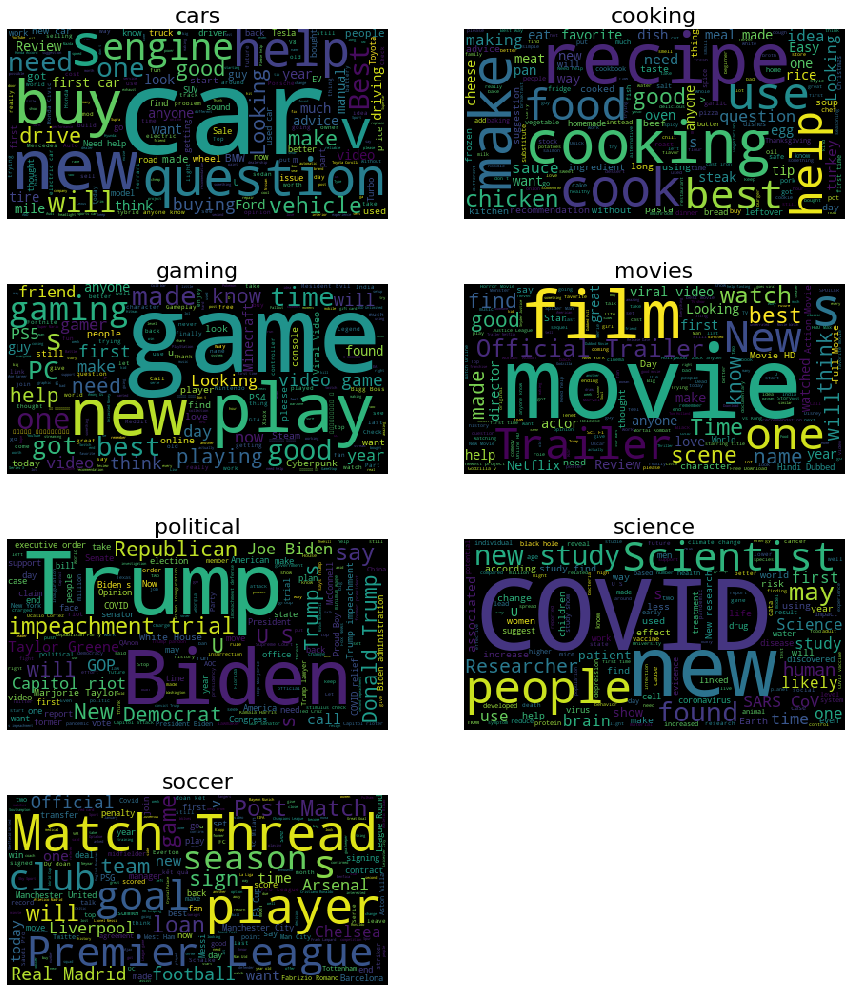

In [11]:
fig = plt.figure(figsize=(15, 18))
for i, cloud in enumerate(clouds):
    fig.add_subplot(4,2,i+1)
    plt.title(titles_categories[i], fontsize = 22)
    plt.axis('off')
    plt.imshow(cloud)
plt.show()

## EDA

In [12]:
missing = titles.isnull().sum()
print('Missing values:\n{}'.format(missing))

Missing values:
Title       0
Category    0
dtype: int64


## Preprocessing

In [13]:
titles['Title'].head(1)

0    Gangster just saying
Name: Title, dtype: object

In [15]:
lemmatizer = WordNetLemmatizer()

remove_punctuation = lambda text: text.translate(str.maketrans('','', string.punctuation))
tokenize = lambda text: nltk.word_tokenize(text)
#remove_whitespace = lambda text: [x.strip(' ') for x in text]
remove_stopwords = lambda text: ' '.join([word for word in text.split() if word not in stopwords])
remove_numbers = lambda text: ' '.join([word for word in text.split() if not word.isdigit()])
lemmatization = lambda text: ' '.join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])

def remove_whitespaces(text):
    texty = []
    for token in text:
        token = token.split()[0]
        texty.append(token)
    return texty

def preprocess(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = lemmatization(text)
    text = tokenize(text)
    text = remove_whitespaces(text)
    return text

In [16]:
titles['Title_new'] = titles.Title.apply(preprocess)

In [19]:
titles.head()

,Title,Category,Title_new
0,Gangster just saying,cars,"[gangster, say]"
1,1 quart motor oil in transmission no choice bu...,cars,"[quart, motor, oil, transmission, choice, driv..."
2,A Hypothetical Car Buying Situation... Need Ad...,cars,"[hypothetical, car, buy, situation, need, advice]"
3,What is cash flow statement,cars,"[cash, flow, statement]"
4,Tyres Services,cars,"[tyres, service]"


In [33]:
titles.drop('Title', axis = 1)

,Category,Title_new
0,cars,"[gangster, say]"
1,cars,"[quart, motor, oil, transmission, choice, driv..."
2,cars,"[hypothetical, car, buy, situation, need, advice]"
3,cars,"[cash, flow, statement]"
4,cars,"[tyres, service]"
...,...,...
19995,soccer,"[george, smith, emile, smithrowe, look, mesut,..."
19996,soccer,"[maradona, siempre, estaras, con, nosotros]"
19997,soccer,"[chelsea, absurd, great, goals]"
19998,soccer,"[lampard, good, enough, attack, game, things, ..."


## Modeling

In [36]:
X = titles['Category']
y = titles.drop('Title_new', axis = 1)

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=.20)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

ValueError: invalid literal for int() with base 10: 'movies'

In [28]:
model = Sequential()

model.add(LSTM(64, dropout=0.2, return_sequences=True, input_shape=(32, 101)))
model.add(LSTM(64, dropout = 0.2,return_sequences=True))
model.add(LSTM(128, dropout = 0.2))
#model.add(LSTM(256, dropout = 0.2))
model.add(Dense(7, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 32, 64)            42496     
_________________________________________________________________
lstm_18 (LSTM)               (None, 32, 64)            33024     
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 175,239
Trainable params: 175,239
Non-trainable params: 0
_________________________________________________________________
